In [1]:
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pandas as pd

In [2]:
df = pd.read_csv("file_path")

# Convert stringified lists in 'tokens' column back to real lists
df['tokens'] = df['tokens'].apply(ast.literal_eval)

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\pradh\AppData\Local\Temp\ipykernel_21536\2319990192.py:1: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv("E:\Academics\Semester-6\DS 203(Prog. for DS)\Project\Code\processed_df.csv")


In [3]:
# Prepare
vector_sizes = list(range(100, 750, 50))
euclidean_results = []
cosine_results = []
inferred_norm_results = []  # To store average norms for each vector size



# Fix 20 sample docs
random.seed(42)
sample_indices = random.sample(list(df.index), 20)

In [4]:

for vec_size in vector_sizes:
    # Prepare tagged data
    tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in zip(df.index, df['tokens'])]

    # Train Doc2Vec model
    model = Doc2Vec(
        tagged_data,
        vector_size=vec_size,
        window=5,
        min_count=1,
        workers=4,
        dm=1,
        epochs=500,
        compute_loss=True
    )

    euclidean_vals = []
    cosine_vals = []
    inferred_norms = []

    for idx in sample_indices:
        inferred_vector = model.infer_vector(df.loc[idx, 'tokens'])
        inferred_norms.append(np.linalg.norm(inferred_vector))  # Track vector norm

        distances = []
        for i in df.index:
            if i == idx:
                continue
            vec = model.dv[str(i)]
            dist = euclidean(inferred_vector, vec)
            distances.append((dist, vec))

        # Top 5 closest in Euclidean
        top5 = sorted(distances, key=lambda x: x[0])[:5]
        top5_dists = [d for d, _ in top5]
        top5_vecs = [v for _, v in top5]

        # Cosine similarities to those top 5
        sims = cosine_similarity([inferred_vector], top5_vecs)[0]

        euclidean_vals.append(np.mean(top5_dists))
        cosine_vals.append(np.mean(sims))

    euclidean_results.append(np.mean(euclidean_vals))
    cosine_results.append(np.mean(cosine_vals))
    inferred_norm_results.append(np.mean(inferred_norms))  # Append average inferred norm


In [5]:
# --------- PLOTS ---------
def plot_line(x, y, ylabel, title, color):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x, y=y, marker='o', color=color, linewidth=2.5)

    for xi, yi in zip(x, y):
        plt.text(xi, yi + 0.001, f"{yi:.3f}", ha='center', va='bottom', fontsize=9)

    plt.title(title, fontsize=15)
    plt.xlabel("Vector Size", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(x, rotation=45)
    plt.tight_layout()
    plt.show()


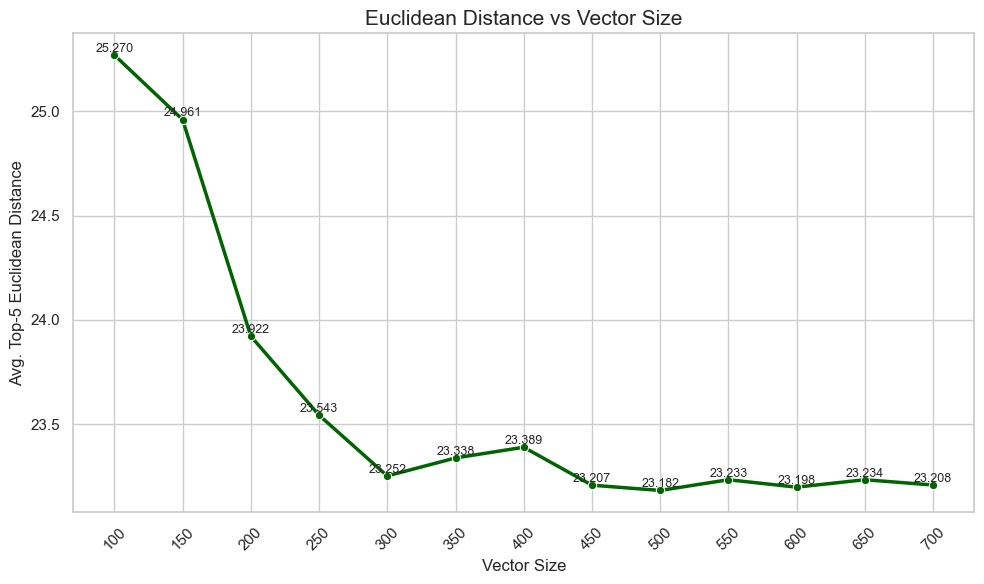

In [6]:
# Seaborn aesthetics
sns.set_theme(style="whitegrid")
plot_line(vector_sizes, euclidean_results, "Avg. Top-5 Euclidean Distance", "Euclidean Distance vs Vector Size", "darkgreen")

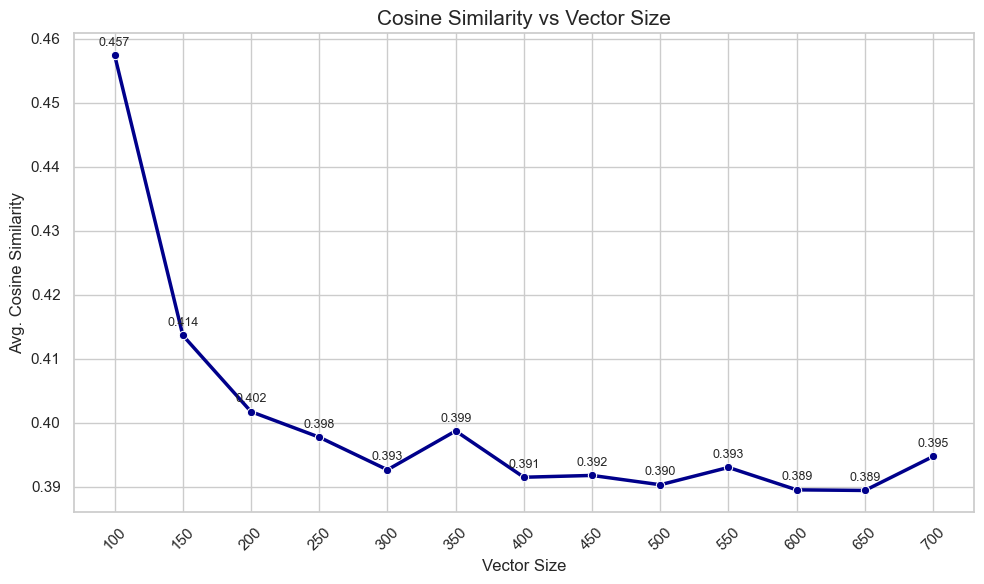

In [7]:
plot_line(vector_sizes, cosine_results, "Avg. Cosine Similarity", "Cosine Similarity vs Vector Size", "darkblue")

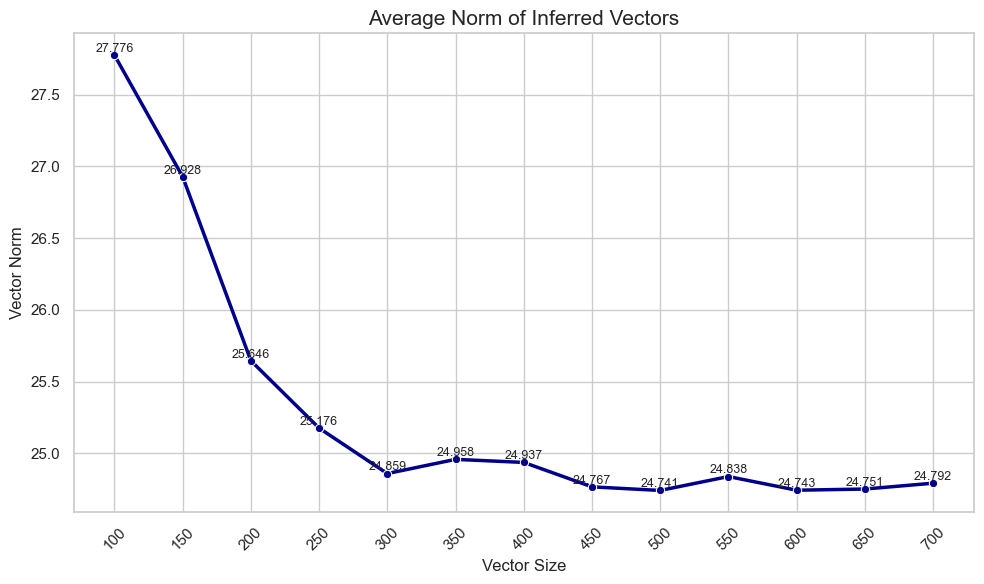

In [9]:

# 📊 Plot: Average Norm of Inferred Vectors vs Vector Size

plot_line(vector_sizes, inferred_norm_results, "Vector Norm", "Average Norm of Inferred Vectors", "darkblue")
